# Spatial reconstruction of the developing human heart
In this notebook present spatial reconstruction of the developing human heart with SageNet. We use the Saptial Transcriptomics (ST) and scRNAseq datasets from [Asp et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0092867419312826). 



## Setup


### Installing SageNet via GitHub
To install the dev. version of SageNet, we install it via GitHub.

In [ ]:
!git clone https://github.com/MarioniLab/sagenet
%cd sagenet
!pip install .

### Installing pytorch geometric

We install [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and its requirments as instructed [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git 

     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 


In [ ]:
!pip install squidpy

### Loading the libraries


In [ ]:
import sagenet as sg 
import scanpy as sc # for plotting 
import anndata as ad # for handling the datasets
import random # for setting a random seed 
import numpy as np 
import copy
from matplotlib import *

### Auxiliary functions and static values




In [ ]:
random.seed(10) # set the random seed for reproducibility

def grid_array(df, n = 2): # auxilary funciton for griding the ST datasets
	min_x = np.min(df['x'])
	max_x = np.max(df['x'])
	to_ret_x = np.ones(len(df))
	for i in range(1, n):
		qr = min_x + i*((max_x - min_x)/n)
		to_ret_x[np.where(df['x'].values > qr)] = i + 1
	min_y = np.min(df['y'])
	max_y = np.max(df['y'])
	to_ret_y = np.ones(len(df))
	for i in range(1, n):
		qr = min_y + i*((max_y - min_y)/n)
		to_ret_y[np.where(df['y'].values > qr)] = i + 1
	temp = to_ret_x * (to_ret_y**3)
	df['grid_' + str(n)] = temp
	return df

def grid_adata(adata, n=[2, 3, 4]): # function to grid the ST datasets 
	df = adata.obs
	for i in n:
		tag = 'grid_' + str(i)
		df_temp = df.groupby('sample').apply(grid_array, n = i)
		temp = np.searchsorted(np.unique(df_temp[tag].values), df_temp[tag].values)
		sg.utils.save_adata(adata, attr='obs', key=tag, data=temp)
	
region_code = { # region dictionary for the ST dataset
    '1' : 'Compact ventricular myocardium',
    '2' : 'Trabecular ventricular myocardium (1)',
    '3' : 'Trabecular ventricular myocardium (2)',
    '4' : 'Trabecular ventricular myocardium (3)',
    '5' : 'Atrial myocardium',
    '6' : 'Outflow tract / large vessels',
    '7' : 'Atrioventricular mesenchyme & valves',
    '8' : 'Mediastinal mesenchyme & vessels',
    '9' : 'Cavities with blood & immune cells',
    '10' : 'Epicardium'
}

region_type_cols = { # the color pallete for regions and cell types 
    'Atrial myocardium' : '#A10037',
    'Compact ventricular myocardium' : '#77441B',
    'Trabecular ventricular myocardium (1)' : '#aa8888',
    'Trabecular ventricular myocardium (2)' : '#826366',
    'Trabecular ventricular myocardium (3)' : '#5B3F45',
    'Outflow tract / large vessels' : '#DC050C',
    'Atrioventricular mesenchyme & valves' : '#cc7818',
    'Mediastinal mesenchyme & vessels' : '#EF4E22',
    'Cavities with blood & immune cells' : '#808000',
    'Epicardium' : '#0F4A9C',
    'Fibroblast-like ' : '#8EC792',
    'Epicardial cells' : '#0F4A9C',
    'Epicardium-derived cells' : '#7BAFDE',
    'Smooth muscle cells ' : '#C9EBFB',
    'Ventricular cardiomyocytes' : '#635547',
    'Myoz2-enriched cardiomyocytes' : '#9e6762',
    'Atrial cardiomyocytes' : '#A10037',
    'Capillary endothelium' : '#B51D8D',
    'Endothelium / pericytes ' : '#ff891c',
    'Erythrocytes' : '#f79083',
    'Cardiac neural crest cells ' : '#E1C239',
    'Immune cells' : '#aeae5c'
}

grid_code = {
  "0" : 'top - right',
  "1" : 'top - middle',
  "2" : 'top - left',
  "3" : 'middle - right',
  "4" : 'middle - middle',
  "5" : 'middle - left',
  "6" : 'bottom - right',
  "7" : 'bottom - middle',
  "8" : 'bottom - left'
}


## The ST reference dataset
Asp et al. (2019), performed a study of developing human heart collected using ST along the dorsal-ventral axis from an embryo collected at 6.5 post-conceptional weeks. ST is a spot-level spatial technology, where each observation typically contains aggregated expression information from a small number of cells. 

The ST heart dataset consists of a total of 3,115 spots (each containing approximately ~30 cells) across nine tissue sections of one developing human heart at the 6.5 week embryonic stage. We downloaded the normalised gene expression data along with region labels and spatial coordinates from the publication website (https://www.spatialresearch.org/resources-published-datasets/doi-10-1016-j-cell-2019-11-025/). Prior to analysis, we restricted the genes to the top 500 highly variable genes as obtained by the Bioconductor package [scran](https://bioconductor.org/packages/release/bioc/html/scran.html).


The ST dataset could be simply downloaded and loaded in the environment by calling `sagenet.DHH_data.ST()`.

In [ ]:
adata_r = sg.DHH_data.ST()
adata_r.obs['y'] = -adata_r.obs['y']
adata_r.obsm['spatial'] = np.array(adata_r.obs[['x','y']])

  0%|          | 0.00/3.21M [00:00<?, ?B/s]

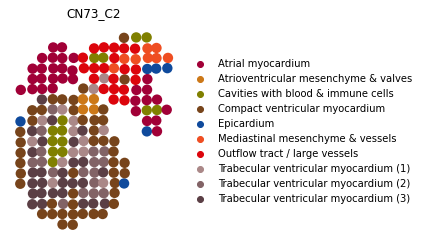

In [ ]:
adata_r.obs['region/cell_type'] = [region_code[k] for k in list(map(str, list(map(int, adata_r.obs['class__'].tolist()))))]
sc.pl.spatial(adata_r[adata_r.obs["sample"] == 'CN73_C2'], palette=region_type_cols, color=['region/cell_type'], spot_size=1, frameon=False, title='CN73_C2')

In [ ]:
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(8,8),constrained_layout=False)
j = 0
for i in ['CN73_C2', 'CN73_D2', 'CN73_E1', 'CN73_E2', 'CN74_C1', 'CN74_D1', 'CN74_D2', 'CN74_E1', 'CN74_E2']:
  i1 = j//3
  i2 = j%3
  sc.pl.spatial(adata_r[adata_r.obs["sample"] == i], palette=region_type_cols, color=['region/cell_type'], spot_size=1, legend_loc=None, frameon=False, title=i, ax=axs[i1, i2])
  j += 1


The heart sections are shown below:

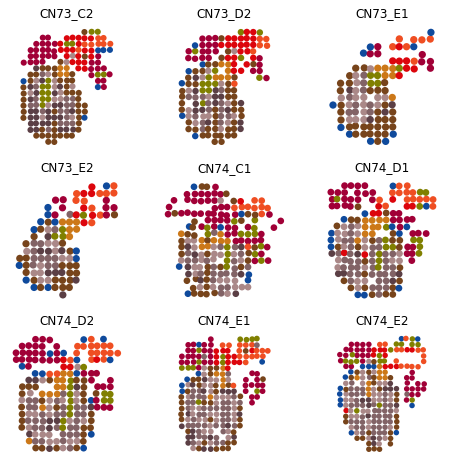

In [ ]:
fig

### Spatial partitionings

We generated consistent partitionings for each ST sample by assigning spots to positions in a square grid. Since ST spots are generated on approximately regular, evenly-spaced positions, we assigned spots to each partition according to their vertical and horizontal position in a 2x2, 3x3, and 4x4 square grid, resulting in three distinct partitionings. 

We apply the auxiliary function `grid_data` on the refernece `AnnData` object. This function adds the grid partitionings as columns to `obs` with names `grid_2`, `grid_3`, and `grid_4`. 

In [ ]:
grid_adata(adata_r, [2, 3, 4])
adata_r.obs['position_3'] = [grid_code[k] for k in list(map(str, list(map(int, adata_r.obs['grid_3'].tolist()))))]
adata_r.obs['class_'] = 0
adata_r

AnnData object with n_obs × n_vars = 1515 × 500
    obs: 'cell_id', 'class__', 'x', 'y', 'sample', 'class_x', 'class_y', 'class_', 'region/cell_type', 'grid_2', 'grid_3', 'grid_4', 'pred_ST_all_grid_2', 'ent_ST_all_grid_2', 'pred_ST_all_grid_3', 'ent_ST_all_grid_3', 'pred_ST_all_grid_4', 'ent_ST_all_grid_4', 'position_3'
    var: 'ID', 'TXID', 'GENEID', 'code', 'GENE', 'ST_all_importance'
    uns: 'X_name'
    obsm: 'spatial', 'dist_map'
    varm: 'adj'

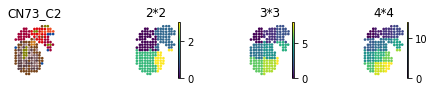

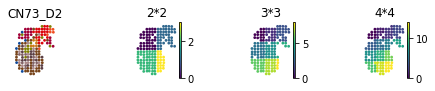

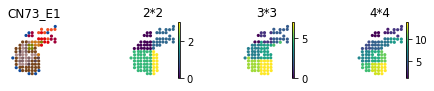

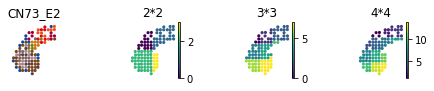

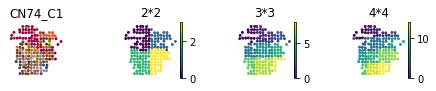

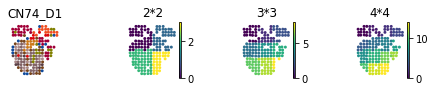

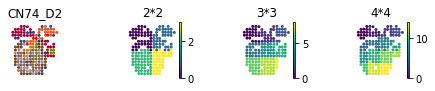

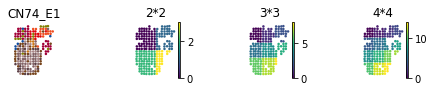

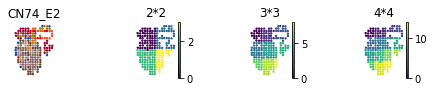

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for i in ['CN73_C2', 'CN73_D2', 'CN73_E1', 'CN73_E2', 'CN74_C1', 'CN74_D1', 'CN74_D2', 'CN74_E1', 'CN74_E2']:
  with rc_context({'figure.figsize': (1, 1)}):
    sc.pl.spatial(adata_r[adata_r.obs["sample"] == i], color=['region/cell_type', 'grid_2', 'grid_3', 'grid_4'], palette=region_type_cols, frameon=False, ncols=4, spot_size=1, title=[i, '2*2', '3*3', '4*4'], legend_loc=None)

### Gene Interaction Network (GIN)
Next, we use the [graphical LASSO (GLASSO)](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.graphical_lasso.html) algorithm to estimate a global GIN on the ST dataset. SageNet's `glasso` function from implements [scikit-learn's GraphicalLassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLassoCV.html) function, for which we provide 0.5 and 0.75 as the grid for the regularization parameter. 
This function adds the constructed adjacency matrix of the GIN to `varm` with key `adj`.

In [ ]:
%time sg.utils.glasso(adata_r, [0.5, 0.75])
adata_r

CPU times: user 13.6 s, sys: 9.22 s, total: 22.8 s
Wall time: 12.4 s


AnnData object with n_obs × n_vars = 1515 × 500
    obs: 'cell_id', 'class__', 'x', 'y', 'sample', 'class_x', 'class_y', 'class_', 'region/cell_type', 'grid_2', 'grid_3', 'grid_4'
    var: 'ID', 'TXID', 'GENEID', 'code', 'GENE', 'ST_all_importance'
    uns: 'X_name'
    obsm: 'spatial'
    varm: 'adj'

We set the cuda device to be used by pytorch in case it's available:

## Training the model
After specifying the partitionings and constructing the GIN, we can train the graph neural network models. 

### Creating the `sage` object
First, we instantiate a `sage` object to store the parameters and the trained models in the upcoming steps.

In [ ]:
import torch
if torch.cuda.is_available():  
	dev = "cuda:0" 
else:  
	dev = "cpu"  
device = torch.device(dev)
print(device)
sg_obj = sg.sage.sage(device=device) 

### `add_ref` for training and intepreting the model
`add_ref` is used to add a spatial reference to a `sage` object. To do so, we specify the columns from `obs` corresponing the partitionings by setting the `comm_columns` argument. 

In [ ]:
%time sg_obj.add_ref(adata_r, comm_columns=['grid_2', 'grid_3', 'grid_4'], tag='ST_all', epochs=20, verbose = True) 

CPU times: user 32.2 s, sys: 477 ms, total: 32.7 s
Wall time: 35.8 s


### Extracting the Spatially Informative Genes

The most important features of a trained SageNet model can be extracted using [the integrated gradients](https://captum.ai/docs/extension/integrated_gradients) technique. These genes can be interpreted as genes that are required for the accurate prediction of spatial partitions, and can be associated with specific partitions either in terms of presence of gene expression or importantly an absence of expression. 

The gene importance values are automatically computed and stored in the reference dataset by running the `add_ref` function. In the following chunk, we extract the genes which are among the top 5 most important features in classifying cells into at least one partition in at least one partitioning:

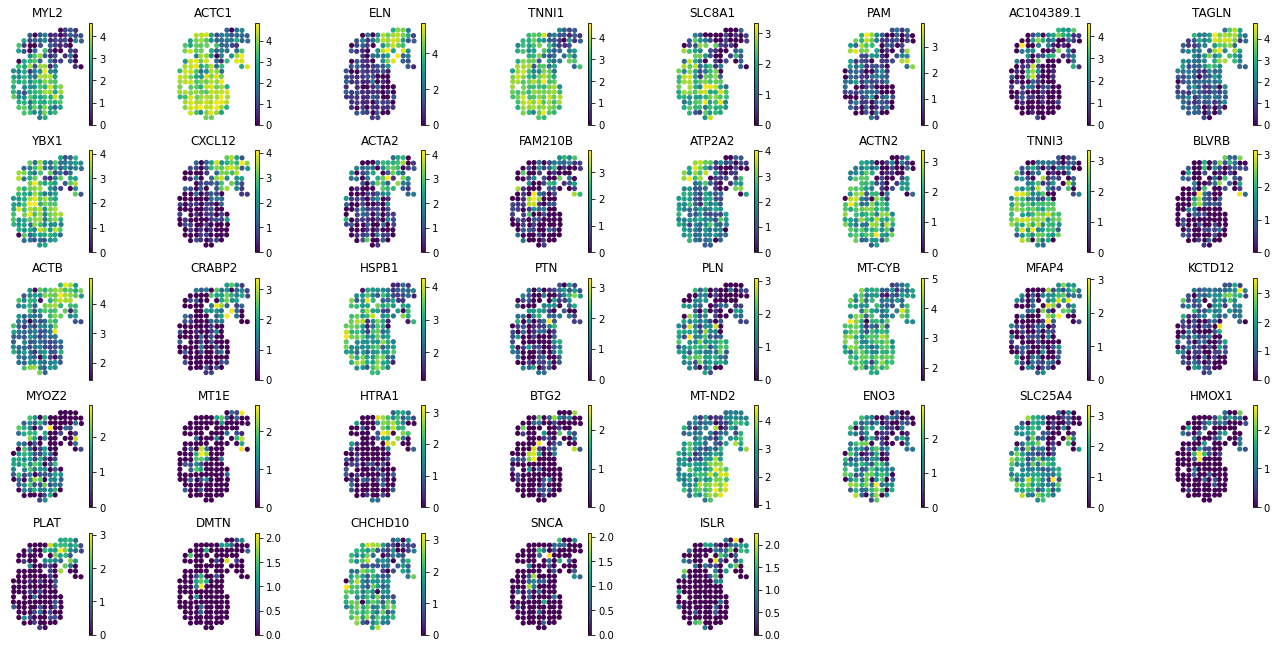

In [ ]:
ind  = np.where(adata_r.var['ST_all_importance'] <= 5)[0]
SIGs = list(adata_r.var_names[ind])
with rc_context({'figure.figsize': (2, 2)}):
  sc.pl.spatial(adata_r[adata_r.obs['sample'] == 'CN73_D2'], color=SIGs, ncols=8, spot_size=1, legend_loc=None, frameon=False)

### Storing and reusing the trained SageNet models
The trained SageNet model (as stored in the `sg_obj`) can be stored as a folder, and then restored again for later use:

In [ ]:
import os
os.makedirs('ST_human_heart') # creat the saving dir
sg_obj.save_model_as_folder('ST_human_heart') # store
%ls ST_human_heart # the stored files in dir ST_human_heart
sg_obj.load_model_as_folder('ST_human_heart') # load

ST_all_grid_2.h5ad    ST_all_grid_3.h5ad    ST_all_grid_4.h5ad
ST_all_grid_2.pickle  ST_all_grid_3.pickle  ST_all_grid_4.pickle


## Building a common coordinate framework by joint spatial reconstruction of the ST samples

We use the trained SageNet model, on all ST data, to jointly embed the distinct ST samples into a common reconstructed space.

### `map_query` for spatial reconstruction of a dissociated dataset
We feed in the ST reference dataset described above as a query dataset to the trained SageNet model by calling the function `map_query`.  

In [ ]:
%time sg_obj.map_query(adata_r)
adata_r

### Predicted distance matrix and low-dimensional embedding
Once the ensemble SageNet model is trained, a probability vector is estimated for each query cell, corresponding to each spatial partitioning. A spatial cell-to-cell distance matrix is calculated using the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence). The `map_query` function computes such a cell-to-cell (or spot-to-spot) distance matrix and stores in `obsm` with key `dist_map`. The predicted cell-to-cell (or spot-to-spot) distance matrix is then used to embed the query cells in a 2 or 3-dimensional space (using e.g., `t-SNE`); this low-dimensional space represents the SageNet spatial reconstruction.

In [ ]:
%%time
dist_adata = ad.AnnData(adata_r.obsm['dist_map'], obs = adata_r.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50, # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.tsne(dist_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 21.6 s, sys: 633 ms, total: 22.2 s
Wall time: 12.1 s


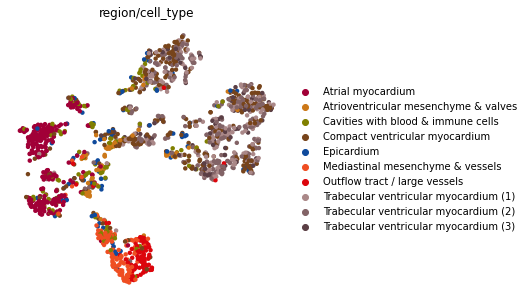

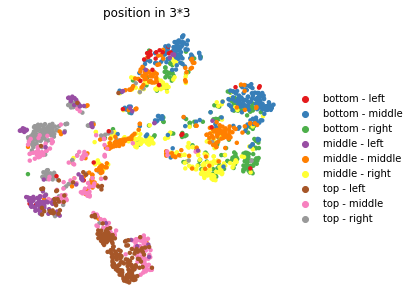

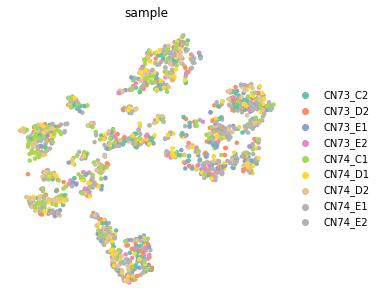

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sc.pl.tsne(dist_adata, color=['region/cell_type'], palette=region_type_cols,  save='heart_ST_SageNet_reconstructed.pdf', frameon=False)
  sc.pl.tsne(dist_adata, color='position_3', palette='Set1', frameon=False, title='position in 3*3')
  sc.pl.tsne(dist_adata, color='sample', palette='Set2', frameon=False)

Interestingly, we were able to recover the separation of functional subregions in the space such as the left and right atrial myocardium, left and right ventricular myocardium and atrioventricular mesenchyme and valves being mapped between atrial and ventricular myocardium, while also observing a high level of mixing of individual samples. This indicates that SageNet is able to leverage multiple spatial references to build a common coordinate system for all tissue samples. 

## Joint reconstruction of ST and scRNAseq datasets
Now, we use the dissociated scRNA-seq data from the same developmental stage  from Asp et al. (2019) to examine their latent spatial positions using SageNet. The scRNAseq dataset could be simply downloaded and loaded in the environment by calling `sagenet.DHH_data.scRNAseq()`. 

In [ ]:
adata_ST_q = sg.DHH_data.ST() # the DHH ST dataset
adata_ST_q.obs['region/cell_type'] = [region_code[key] for key in list(map(str, list(map(int, adata_ST_q.obs['class__'].tolist()))))]
adata_ST_q.obs['dataset'] = 'ST'
adata_scRNAseq_q = sg.DHH_data.scRNAseq() # the DHH scRNAseq dataset
adata_scRNAseq_q.obs['region/cell_type'] = adata_scRNAseq_q.obs['celltype']
adata_scRNAseq_q.obs['dataset'] = 'scRNAseq'
adata_q = ad.concat([adata_ST_q, adata_scRNAseq_q])

  0%|          | 0.00/7.77M [00:00<?, ?B/s]

In [ ]:
sg_obj.map_query(adata_q)

In [ ]:
dist_adata = ad.AnnData(adata_q.obsm['dist_map'], obs = adata_q.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50, # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.tsne(dist_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


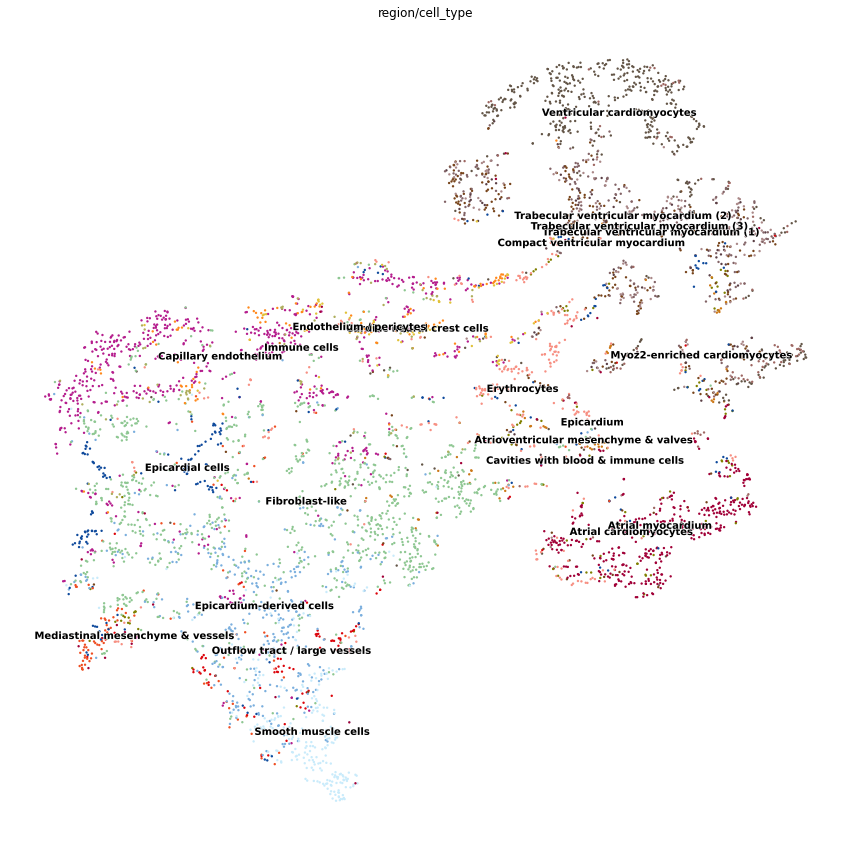

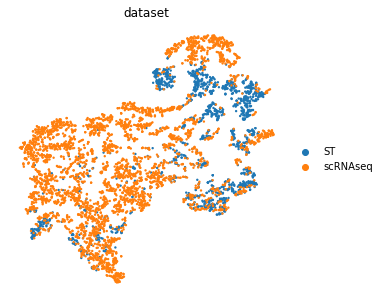

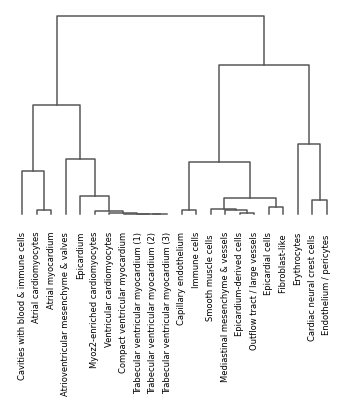

In [ ]:
with rc_context({'figure.figsize': (15, 15)}):
  sc.pl.tsne(dist_adata, color='region/cell_type', palette=region_type_cols,  save='heart_joint_SageNet_reconstructed.pdf', legend_loc='on data',
            frameon=False, legend_fontsize=10, legend_fontoutline=1)
with rc_context({'figure.figsize': (5, 5)}):
  sc.pl.tsne(dist_adata, color='dataset',  save='heart_joint_SageNet_reconstructed.pdf',
            frameon=False, legend_fontsize=10, legend_fontoutline=1)
ax = sc.pl.dendrogram(dist_adata, 'region/cell_type')

In [ ]:
adata_q.obsp['spatial_connectivities'] = dist_adata.obsp['connectivities']
adata_q.obsp['spatial_distances'] = dist_adata.obsp['distances']
sq.gr.nhood_enrichment(adata_q, cluster_key="cell_type")
sq.pl.nhood_enrichment(adata_q, cluster_key="cell_type", method="ward")

The plots above demonstrate that the SageNet model, trained using spot-level ST data, is directly transferable to single-cell level based resolution with correspondence of known cell types including atrial and ventricular cardiomyocytes and their corresponding myocardium, and epicardium-derived and smooth muscle cells with vessels.

We can also take a look at the expression of SIGs we found above:

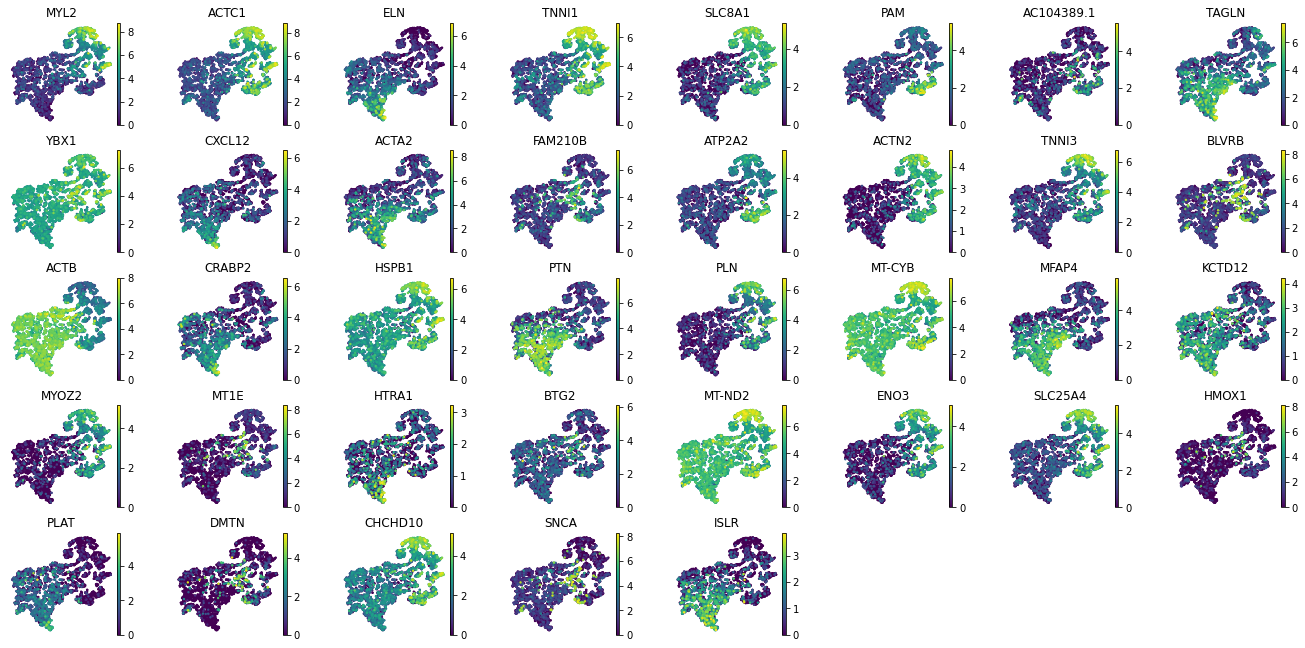

In [ ]:
adata_q.obsm['tsne'] = dist_adata.obsm['X_tsne']
sc.pl.dotplot(adata_q, SIGs, groupby='region/cell_type', dendrogram=True)
with rc_context({'figure.figsize': (2, 2)}):
  sc.pl.tsne(adata_q, color=SIGs, ncols=8, legend_loc=None, frameon=False)

### Mapping confidence scores
For each query cell, we additionally calculate a confidence score using Shannon’s entropy on the probability vectors, representing the degree of confidence in reconstructing the physical space:

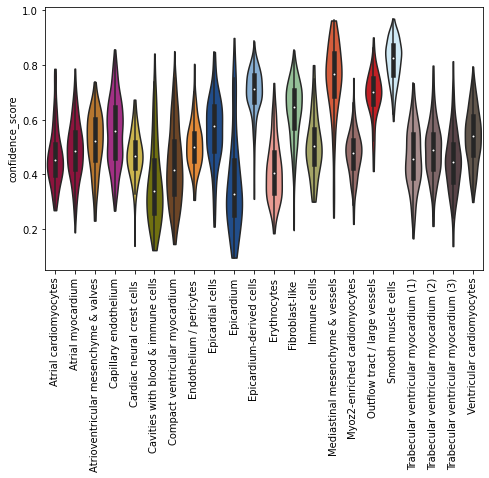

In [ ]:
adata_q.obs['confidence_score'] = (3 - (adata_q.obs['ent_ST_all_grid_2'] + adata_q.obs['ent_ST_all_grid_3'] + adata_q.obs['ent_ST_all_grid_4']))/3
with rc_context({'figure.figsize': (7, 5)}):
  sc.pl.violin(adata_q, ['confidence_score'], groupby='region/cell_type', palette=region_type_cols, stripplot=False, inner='box', rotation=90)

Remarkably, we observed a similar range of high mapping confidence for the unseen scRNA-seq cells as the reference ST-derived regions. Taken together, these results suggest that SageNet is highly effective in integrating spatial and non-spatial data of different technologies and facilitates the understanding of developmental heart biology.